<a href="https://colab.research.google.com/github/hubertrykala93/eye-diseases-image-classification/blob/main/eye_diseases_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [303]:
import os
from shutil import copyfile, rmtree
from typing import Union, List, Tuple, Set, Dict
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img, img_to_array
from keras_preprocessing.image.image_data_generator import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import SGD

In [304]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use(style='ggplot')

# Collecting Data and Remove Unnecessary Files

In [305]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download --force -d gunavenkatdoddi/eye-diseases-classification

Saving kaggle.json to kaggle (7).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 731M/736M [00:03<00:00, 91.9MB/s]
100% 736M/736M [00:03<00:00, 196MB/s] 


In [306]:
!unzip -q eye-diseases-classification.zip
!rm rf eye-diseases-classification.zip

rm: cannot remove 'rf': No such file or directory


In [307]:
os.rename(src='/content/dataset', dst='/content/files')

# Images Exploration

In [308]:
BASE_DIR = '/content/files'
DATASET_DIR = '/content/dataset'

if not os.path.exists(DATASET_DIR):
  os.mkdir(path=DATASET_DIR)

In [309]:
def show_images(kind: str, id: int = 0, random_choice: bool = False,
                make_subplots: bool = False) -> None:
    """
    Show image from file directories.

    Parameters:
    ----------
    kind: str
      Must be in 'cataract', 'diabetic_retinopathy', 'glaucoma' or normal'.

    id: int
      Index of image, while index will be higher the length of files in directory
      then will raise error.

    random_choice: bool
      If random_choice is True, function choose random image and return it.

    make_subplots: bool
      If make_subplots is True, function choose 12 random images
      and return subplots from this images.

    Returns:
    -------
    matplotlib.pyplot.Axes
    """

    filenames = dict(enumerate(os.listdir(path=os.path.join(BASE_DIR, kind))))

    if id >= len(filenames):
        raise KeyError(f'Wrong index, maximum index is {len(filenames)}.')
    else:
        if not make_subplots:
            if random_choice == False:
                img = load_img(path=os.path.join(BASE_DIR, kind, filenames[id]), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=filenames[id])
                plt.axis('off')
                plt.grid(visible=False)

                plt.show()

            else:
                random_id = filenames[np.random.choice(a=len(filenames))]

                img = load_img(path=os.path.join(BASE_DIR, kind, random_id), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=random_id)
                plt.axis('off')
                plt.grid(visible=False)

                plt.show()

        else:
            indexes = []

            while len(indexes) != 12:
                indexes = list(indexes)
                indexes.append(np.random.choice(a=len(filenames)))

                indexes = set(indexes)

            indexes = list(indexes)

            for i, index in enumerate(indexes):
                plt.subplot(4, 3, i + 1)

                img = load_img(path=os.path.join(BASE_DIR, kind, filenames[index]), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=filenames[index], fontdict={
                    'size': 10
                })
                plt.axis('off')
                plt.grid(visible=False)

            plt.show()

Cataract

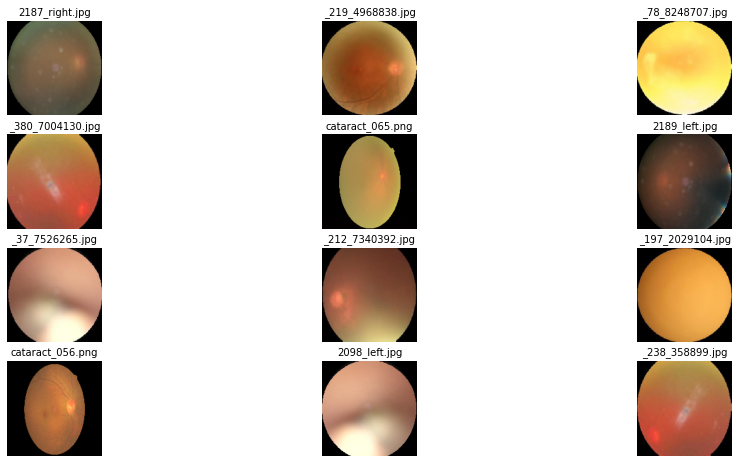

In [310]:
show_images(kind='cataract', id=990, random_choice=False, make_subplots=True)

Diabetic Retinopathy

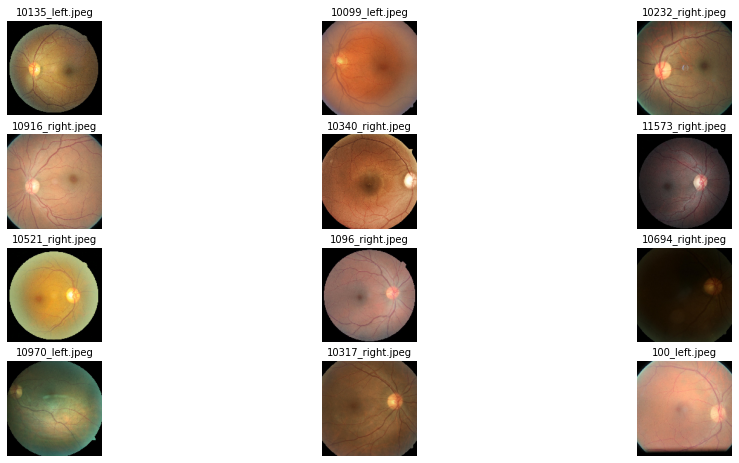

In [311]:
show_images(kind='diabetic_retinopathy', id=990, random_choice=False, make_subplots=True)

Glaucoma

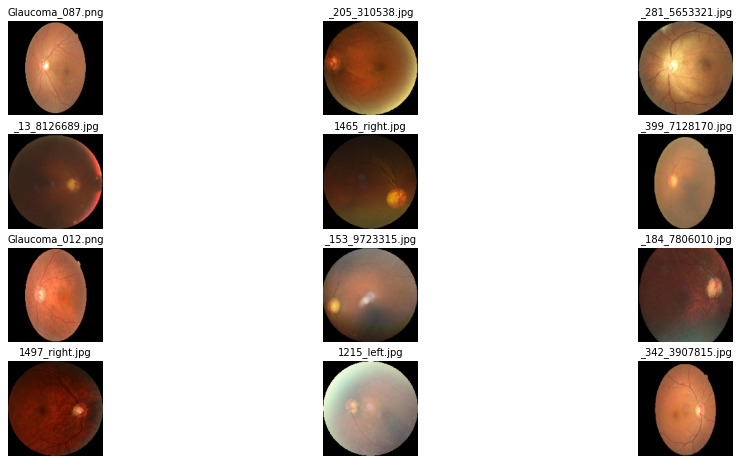

In [312]:
show_images(kind='glaucoma', id=990, random_choice=False, make_subplots=True)

Normal

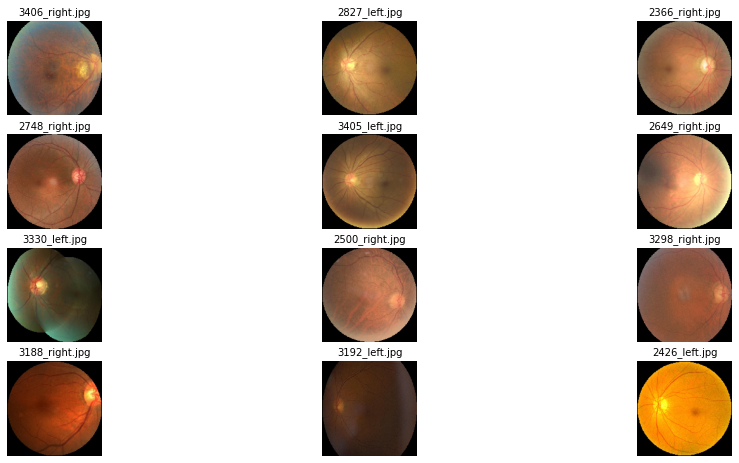

In [313]:
show_images(kind='normal', id=990, random_choice=False, make_subplots=True)

# Creating Dataset with Train and Test Files

In [314]:
cataract_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'cataract'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

diabetic_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'diabetic_retinopathy'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

glaucoma_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'glaucoma'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

normal_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'normal'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

In [315]:
SIZE = min([len(cataract_filenames), len(diabetic_filenames), len(glaucoma_filenames),
        len(normal_filenames)])

TRAIN_SIZE = int(np.floor(SIZE * 0.7))
VALIDATION_SIZE = int(np.floor(SIZE * 0.25))
TEST_SIZE = SIZE - TRAIN_SIZE - VALIDATION_SIZE

TRAIN_INDEX = TRAIN_SIZE
VALIDATION_INDEX = TRAIN_SIZE + VALIDATION_SIZE
TEST_INDEX = SIZE

In [316]:
cataract_filenames = cataract_filenames[:SIZE]
diabetic_filenames = diabetic_filenames[:SIZE]
glaucoma_filenames = glaucoma_filenames[:SIZE]
normal_filenames = normal_filenames[:SIZE]

In [317]:
train_dir = os.path.join(DATASET_DIR, 'train')
validation_dir = os.path.join(DATASET_DIR, 'validation')
test_dir = os.path.join(DATASET_DIR, 'test')

train_cataract_dir = os.path.join(train_dir, 'cataract')
train_diabetic_dir = os.path.join(train_dir, 'diabetic_retinopathy')
train_glaucoma_dir = os.path.join(train_dir, 'glaucoma')
train_normal_dir = os.path.join(train_dir, 'normal')

validation_cataract_dir = os.path.join(validation_dir, 'cataract')
validation_diabetic_dir = os.path.join(validation_dir, 'diabetic_retinopathy')
validation_glaucoma_dir = os.path.join(validation_dir, 'glaucoma')
validation_normal_dir = os.path.join(validation_dir, 'normal')

test_cataract_dir = os.path.join(test_dir, 'cataract')
test_diabetic_dir = os.path.join(test_dir, 'diabetic_retinopathy')
test_glaucoma_dir = os.path.join(test_dir, 'glaucoma')
test_normal_dir = os.path.join(test_dir, 'normal')

In [318]:
directories = [train_dir, validation_dir, test_dir, train_cataract_dir, train_diabetic_dir,
               train_glaucoma_dir, train_normal_dir, validation_cataract_dir,
               validation_diabetic_dir, validation_glaucoma_dir, validation_normal_dir,
               test_cataract_dir, test_diabetic_dir, test_glaucoma_dir, test_normal_dir]

for dir in directories:
  if not os.path.exists(path=dir):
    os.mkdir(path=dir)

In [319]:
def create_sets() -> None:
  """
  Copying files from files directory to dataset directory in order to
  creating cataract, diabetic_retinopathy, glaucoma and normal train and test sets.

  Parameters:
  ----------
  directories: list
    List of strings. String must be path to the file.

  Returns:
  -------
  None
  """
  for i, file_1 in enumerate(cataract_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'cataract', file_1)
      dst = os.path.join(train_cataract_dir, file_1)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'cataract', file_1)
      dst = os.path.join(validation_cataract_dir, file_1)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'cataract', file_1)
      dst = os.path.join(test_cataract_dir, file_1)
      copyfile(src=src, dst=dst)

  for i, file_2 in enumerate(diabetic_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'diabetic_retinopathy', file_2)
      dst = os.path.join(train_diabetic_dir, file_2)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'diabetic_retinopathy', file_2)
      dst = os.path.join(validation_diabetic_dir, file_2)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'diabetic_retinopathy', file_2)
      dst = os.path.join(test_diabetic_dir, file_2)
      copyfile(src=src, dst=dst)

  for i, file_3 in enumerate(glaucoma_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'glaucoma', file_3)
      dst = os.path.join(train_glaucoma_dir, file_3)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'glaucoma', file_3)
      dst = os.path.join(validation_glaucoma_dir, file_3)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'glaucoma', file_3)
      dst = os.path.join(test_glaucoma_dir, file_3)
      copyfile(src=src, dst=dst)

  for i, file_4 in enumerate(normal_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'normal', file_4)
      dst = os.path.join(train_normal_dir, file_4)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'normal', file_4)
      dst = os.path.join(validation_normal_dir, file_4)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'normal', file_4)
      dst = os.path.join(test_normal_dir, file_4)
      copyfile(src=src, dst=dst)

In [320]:
create_sets()

In [321]:
print(f'Train Cataract Dir Files -> {len(os.listdir(path=train_cataract_dir))}')
print(f'Train Diabetic Dir Files -> {len(os.listdir(path=train_diabetic_dir))}')
print(f'Train Glaucoma Dir Files -> {len(os.listdir(path=train_glaucoma_dir))}')
print(f'Train Normal Dir Files -> {len(os.listdir(path=train_normal_dir))}')

print(f'Validation Cataract Dir Files -> {len(os.listdir(path=validation_cataract_dir))}')
print(f'Validation Diabetic Dir Files -> {len(os.listdir(path=validation_diabetic_dir))}')
print(f'Validation Glaucoma Dir Files -> {len(os.listdir(path=validation_glaucoma_dir))}')
print(f'Validation Normal Dir Files -> {len(os.listdir(path=validation_normal_dir))}')

print(f'Test Cataract Dir Files -> {len(os.listdir(path=test_cataract_dir))}')
print(f'Test Diabetic Dir Files -> {len(os.listdir(path=test_diabetic_dir))}')
print(f'Test Glaucoma Dir Files -> {len(os.listdir(path=test_glaucoma_dir))}')
print(f'Test Normal Dir Files -> {len(os.listdir(path=test_normal_dir))}')

Train Cataract Dir Files -> 705
Train Diabetic Dir Files -> 705
Train Glaucoma Dir Files -> 705
Train Normal Dir Files -> 705
Validation Cataract Dir Files -> 251
Validation Diabetic Dir Files -> 251
Validation Glaucoma Dir Files -> 251
Validation Normal Dir Files -> 251
Test Cataract Dir Files -> 51
Test Diabetic Dir Files -> 51
Test Glaucoma Dir Files -> 51
Test Normal Dir Files -> 51


In [322]:
rmtree(path=BASE_DIR, ignore_errors=True)

# Creating Image Generators

In [323]:
train_datagen = ImageDataGenerator(rescale=1. /255., rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True,
                                   shear_range=0.2, zoom_range=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255.)

test_datagen = ImageDataGenerator(rescale=1. /255.)

In [324]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  class_mode='categorical',
                                                  target_size=(150, 150))

Found 2820 images belonging to 4 classes.
Found 1004 images belonging to 4 classes.
Found 204 images belonging to 4 classes.


# Building Model

In [325]:
def loss_plot(hist):
    train_epochs = list(range(1, len(hist.history['loss']) + 1))
    valid_epochs = list(range(1, len(hist.history['val_loss']) + 1))
    train_losses = hist.history['loss']
    valid_losses = hist.history['val_loss']

    train_min_loss = min(dict(zip(train_epochs, train_losses)).items(), key=lambda x: x[1])
    valid_min_loss = min(dict(zip(valid_epochs, valid_losses)).items(), key=lambda x: x[1])

    plt.plot(train_epochs, hist.history['loss'], linewidth=1, color='blue', label='Training Loss')
    plt.plot(train_min_loss[0], train_min_loss[1], color='black', marker='o',
             label=f'Training Best Epoch - {train_min_loss[0]}')
    plt.plot(valid_epochs, hist.history['val_loss'], linewidth=1, color='red', label='Validation Loss')
    plt.plot(valid_min_loss[0], valid_min_loss[1], color='black', marker='o',
             label=f'Validation Best Epoch - {valid_min_loss[0]}')
    plt.legend(loc='best')
    plt.title(label='Training & Validation Loss')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.show()

In [326]:
def accuracy_plot(hist):
  epochs = list(range(1, len(hist.history['accuracy']) + 1))

  plt.plot(epochs, hist.history['accuracy'], marker='o', linewidth=1, label='Training Accuracy', color='blue')
  plt.plot(epochs, hist.history['val_accuracy'], marker='o', linewidth=1, label='Validation Accuracy', color='red')
  plt.title(label='Training & Validation Accuracy')
  plt.legend(loc='best')
  plt.xlabel(xlabel='Epochs')
  plt.ylabel(ylabel='Accuracy')
  plt.show()

In [327]:
model = Sequential(layers=[
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 3),
           padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(rate=0.2),
    Dense(units=256, activation='relu'),
    Dense(units=4, activation='softmax')
])

In [328]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_516 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_517 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_518 (Conv2D)         (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 18, 18, 128)    

In [329]:
model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [330]:
model_history = model.fit_generator(generator=train_generator, steps_per_epoch=int(np.ceil(TRAIN_SIZE / 128)),
                              epochs=100, verbose=1, validation_data=validation_generator,
                              validation_steps=int(np.ceil(VALIDATION_SIZE / 128)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
6/6 [==============================] - 4s 706ms/step - loss: 1.3722 - accuracy: 0.2865 - val_loss: 1.3696 - val_accuracy: 0.2812
Epoch 2/100
6/6 [==============================] - 4s 611ms/step - loss: 1.3910 - accuracy: 0.2396 - val_loss: 1.3788 - val_accuracy: 0.2031
Epoch 3/100
6/6 [==============================] - 3s 569ms/step - loss: 1.3729 - accuracy: 0.2917 - val_loss: 1.3725 - val_accuracy: 0.3594
Epoch 4/100
6/6 [==============================] - 4s 703ms/step - loss: 1.3696 - accuracy: 0.2865 - val_loss: 1.3379 - val_accuracy: 0.4531
Epoch 5/100
6/6 [==============================] - 5s 885ms/step - loss: 1.3550 - accuracy: 0.2969 - val_loss: 1.3254 - val_accuracy: 0.3281
Epoch 6/100
6/6 [==============================] - 3s 599ms/step - loss: 1.3742 - accuracy: 0.3333 - val_loss: 1.3705 - val_accuracy: 0.3125
Epoch 7/100
6/6 [==============================] - 3s 504ms/step - loss: 1.3394 - accuracy: 0.3281 - val_loss: 1.3623 - val_accuracy: 0.2500
Epoch 8/100
6

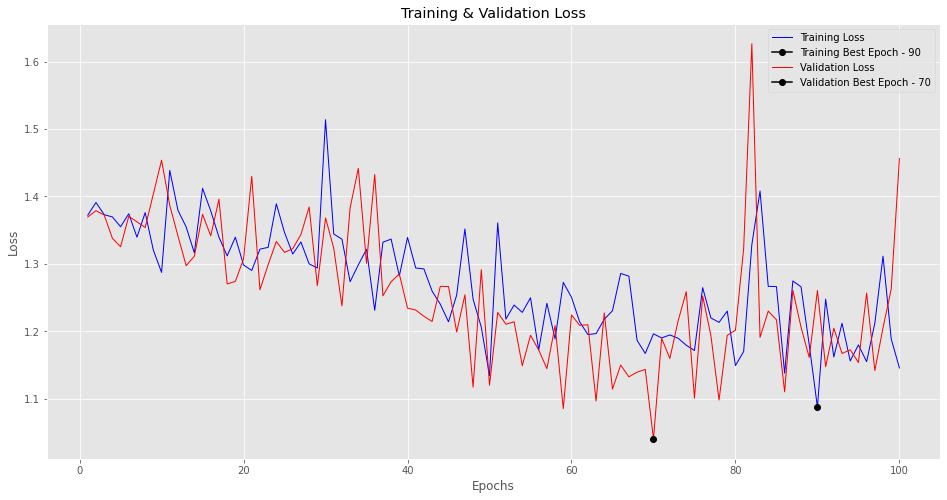

In [331]:
loss_plot(hist=model_history)

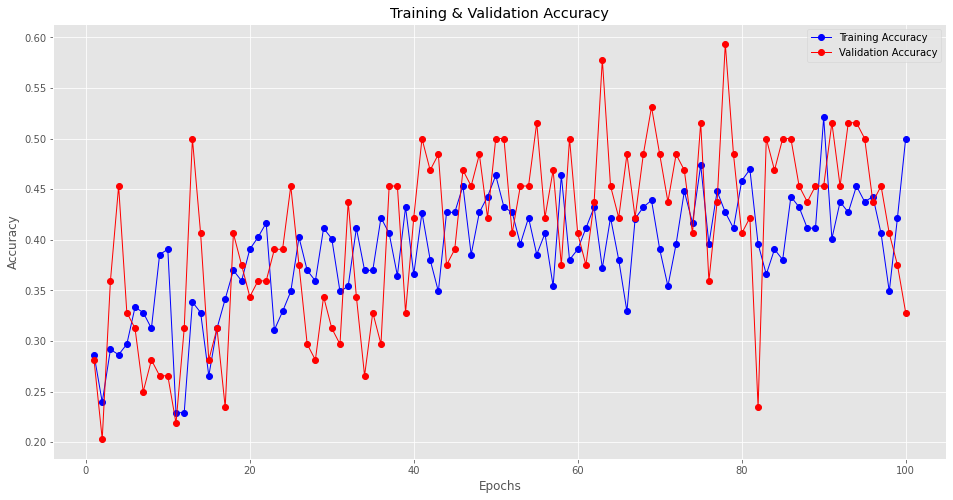

In [332]:
accuracy_plot(hist=model_history)

# Transfer Learning with VGG16

In [333]:
vgg_base_model = VGG16(include_top=False, weights='imagenet',
                       input_shape=(150, 150, 3), pooling='avg', classes=4)

In [334]:
def set_trainable(model, layer_name: str, return_layers: bool = False) -> List:
  """
  Set trainabled layers to non-trainabled. All layers before layer_name will be
  non-trainable.

  Parameters:
  ----------
  model: keras.Model
    Model from Keras.

  layer_name: str
    Name of layer to start set to trainable.

  Returns:
  -------
  list:
    Return list of names with trainable layers.
  """

  trainable_layers = []

  layer_name_index = dict(enumerate([layer.name for layer in model.layers]))

  layer_index = 0

  for index, value in layer_name_index.items():
    if value == layer_name:
        layer_index += index

        for layer in model.layers[:layer_index]:
            layer.trainable = False

  for layer in model.layers:
    if layer.trainable == True:
      trainable_layers.append(layer.name)

  if return_layers:
    return trainable_layers

In [335]:
set_trainable(model=vgg_base_model, layer_name='block5_conv1', return_layers=True)

['block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'global_average_pooling2d_10']

In [336]:
vgg_model = Sequential(layers=[
    vgg_base_model,
    Flatten(),
    Dropout(rate=0.2),
    Dense(units=256, activation='relu'),
    Dense(units=4, activation='softmax')
])

In [337]:
vgg_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_23 (Flatten)        (None, 512)               0         
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_47 (Dense)            (None, 256)               131328    
                                                                 
 dense_48 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 14,847,044
Trainable params: 7,211,780
Non-trainable params: 7,635,264
_________________________________________________________________


In [338]:
vgg_model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [339]:
vgg_history = vgg_model.fit_generator(generator=train_generator, steps_per_epoch=int(np.ceil(TRAIN_SIZE / 128)),
                                  epochs=100, validation_steps=int(np.ceil(VALIDATION_SIZE / 128)),
                                  validation_data=validation_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
6/6 [==============================] - 6s 835ms/step - loss: 1.7963 - accuracy: 0.2604 - val_loss: 1.3833 - val_accuracy: 0.2031
Epoch 2/100
6/6 [==============================] - 4s 706ms/step - loss: 1.4123 - accuracy: 0.2500 - val_loss: 1.3837 - val_accuracy: 0.3125
Epoch 3/100
6/6 [==============================] - 4s 664ms/step - loss: 1.3851 - accuracy: 0.2760 - val_loss: 1.3686 - val_accuracy: 0.3906
Epoch 4/100
6/6 [==============================] - 4s 578ms/step - loss: 1.3970 - accuracy: 0.3333 - val_loss: 1.4079 - val_accuracy: 0.2969
Epoch 5/100
6/6 [==============================] - 3s 615ms/step - loss: 1.3335 - accuracy: 0.3594 - val_loss: 1.3202 - val_accuracy: 0.3750
Epoch 6/100
6/6 [==============================] - 4s 610ms/step - loss: 1.3450 - accuracy: 0.3542 - val_loss: 1.4030 - val_accuracy: 0.2969
Epoch 7/100
6/6 [==============================] - 4s 709ms/step - loss: 1.2758 - accuracy: 0.3490 - val_loss: 1.5094 - val_accuracy: 0.3594
Epoch 8/100
6

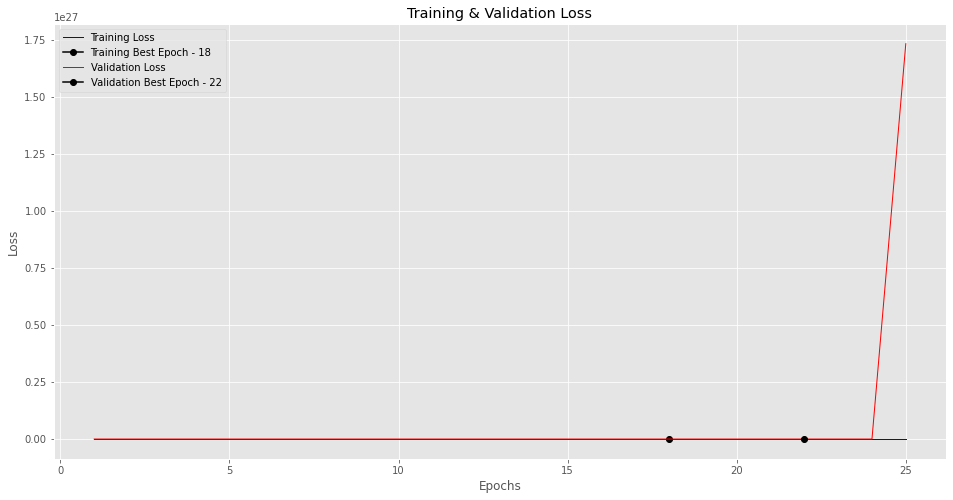

In [340]:
loss_plot(hist=vgg_history)

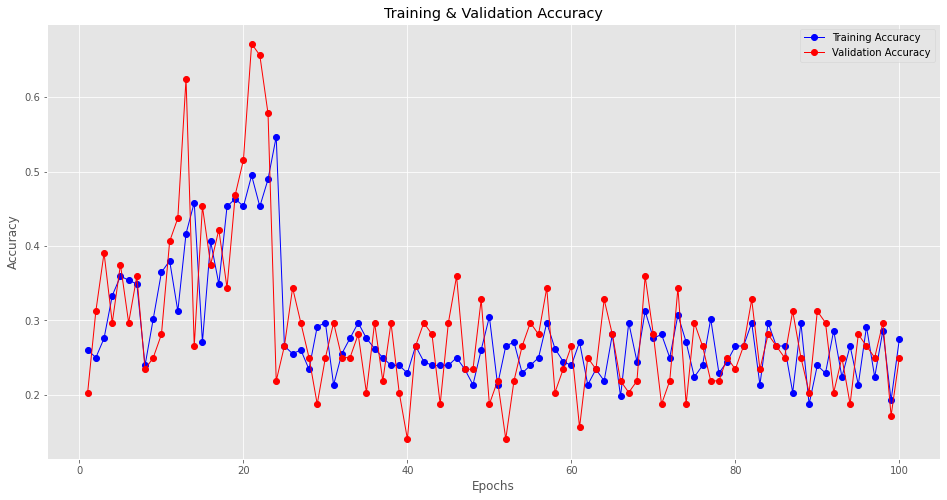

In [341]:
accuracy_plot(hist=vgg_history)

# Transfer Learning with InceptionV3

In [342]:
inception_base_model = InceptionV3(include_top=False, weights='imagenet',
                                   input_shape=(150, 150, 3), pooling='avg', classes=4)

In [343]:
inception_model = Sequential(layers=[
    inception_base_model,
    Flatten(),
    Dropout(rate=0.2),
    Dense(units=256, activation='relu'),
    Dense(units=4, activation='softmax')
])

In [344]:
inception_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_24 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0         
                                                                 
 dense_49 (Dense)            (None, 256)               524544    
                                                                 
 dense_50 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 22,328,356
Trainable params: 22,293,924
Non-trainable params: 34,432
_________________________________________________________________


In [345]:
inception_model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [346]:
inception_history = inception_model.fit_generator(generator=train_generator,
                                                  steps_per_epoch=int(np.ceil(TRAIN_SIZE / 128)),
                                                  epochs=100, verbose=1, validation_data=validation_generator,
                                                  validation_steps=int(np.ceil(VALIDATION_SIZE / 128)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
6/6 [==============================] - 11s 912ms/step - loss: 1.8705 - accuracy: 0.2656 - val_loss: 45.9530 - val_accuracy: 0.2656
Epoch 2/100
6/6 [==============================] - 4s 625ms/step - loss: 1.3559 - accuracy: 0.3906 - val_loss: 67.6836 - val_accuracy: 0.2500
Epoch 3/100
6/6 [==============================] - 4s 612ms/step - loss: 1.1695 - accuracy: 0.4844 - val_loss: 5.5482 - val_accuracy: 0.3125
Epoch 4/100
6/6 [==============================] - 4s 654ms/step - loss: 1.2059 - accuracy: 0.5260 - val_loss: 1.4972 - val_accuracy: 0.4062
Epoch 5/100
6/6 [==============================] - 3s 579ms/step - loss: 1.0668 - accuracy: 0.5208 - val_loss: 1.9445 - val_accuracy: 0.3125
Epoch 6/100
6/6 [==============================] - 3s 543ms/step - loss: 0.9649 - accuracy: 0.6302 - val_loss: 1.1305 - val_accuracy: 0.5625
Epoch 7/100
6/6 [==============================] - 4s 663ms/step - loss: 1.0567 - accuracy: 0.5521 - val_loss: 1.1577 - val_accuracy: 0.5156
Epoch 8/10

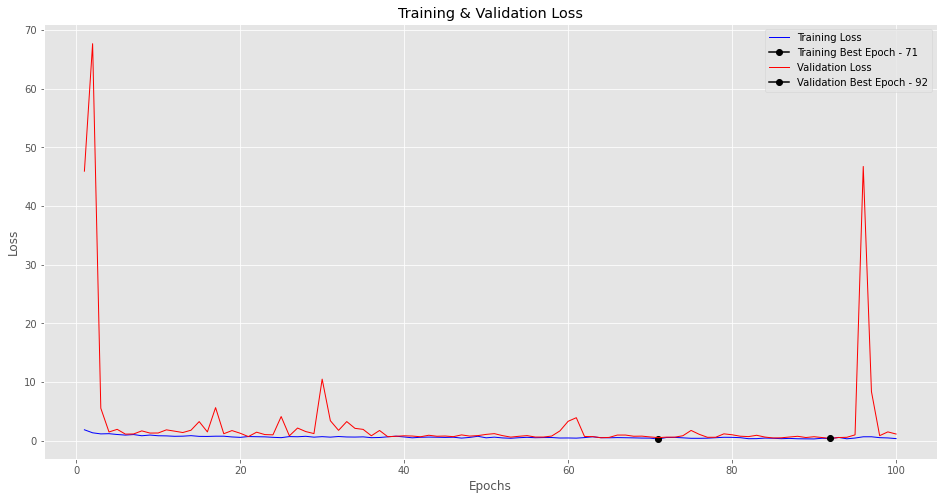

In [347]:
loss_plot(hist=inception_history)

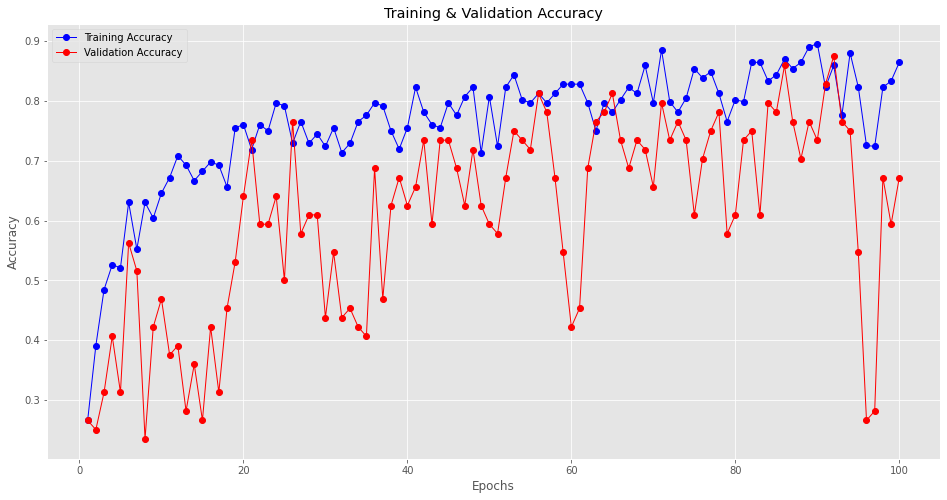

In [348]:
accuracy_plot(hist=inception_history)